In [2]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from preprocessing import create_loader
from evaluate import predict, display_image_grid, conf_matrix
from classifier import create_model, train, validate

In [3]:
dataset_directory = Path('dataset')
cats_directory = dataset_directory / 'train/cats'
dogs_directory = dataset_directory / 'train/dogs'

In [4]:
# Список файлов для дальнейшей предообработки
cats_images_filepaths = sorted([cats_directory / f for f in os.listdir(cats_directory)])
dogs_images_filepaths = sorted([dogs_directory / f for f in os.listdir(dogs_directory)])
images_filepaths = [*cats_images_filepaths, *dogs_images_filepaths]

correct_images_filepaths = []
for i in tqdm(images_filepaths):
    if cv2.imread(str(i)) is not None:
        correct_images_filepaths.append(str(i))
test_images_filepaths = correct_images_filepaths[-10:]

100%|██████████| 10000/10000 [00:30<00:00, 330.62it/s]


In [5]:
# Список параметров для НС
params = {
        "model": "resnet50",
        "device": 'cuda' if torch.cuda.is_available() else 'cpu',
        "lr": 0.001,
        "epochs": 2,
    }

In [6]:
# Создание экземпляра модели
model, criterion, optimizer = create_model(params)
# Создание датасетов
train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = create_loader(correct_images_filepaths)

C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


6000
3600
400


In [7]:
len(test_loader.dataset)

400

In [8]:
test_loader.dataset[1][1]

1.0

In [9]:
history_training = {'accuracy':[],'loss':[]}
history_validation = {'accuracy':[],'loss':[]}
for epoch in range(1, params["epochs"] + 1):
    history_train = train(train_loader, model, criterion, optimizer, epoch, params)
    history_training['accuracy'].append((history_train[0]))
    history_training['loss'].append((history_train[1]))

    history_val = (validate(val_loader, model, criterion, epoch, params))
    history_validation['accuracy'].append((history_val[0]))
    history_validation['loss'].append((history_val[1]))

Epoch: 1. Train.      Loss: 0.763 | Accuracy: 0.571: 100%|██████████| 94/94 [07:34<00:00,  4.84s/it]
Epoch: 1. Validation. Loss: 0.867 | Accuracy: 0.574: 100%|██████████| 57/57 [01:34<00:00,  1.66s/it]
Epoch: 2. Train.      Loss: 0.675 | Accuracy: 0.607:  63%|██████▎   | 59/94 [05:18<03:08,  5.37s/it]

In [ ]:
list(map(np.mean, history_training['accuracy']))

[0.5785682626227115, 0.6201241136865413]

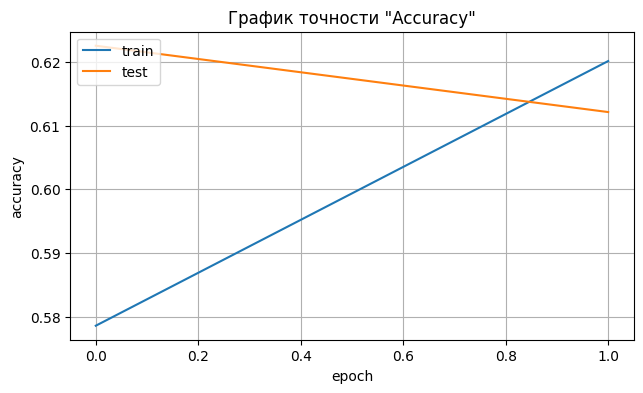

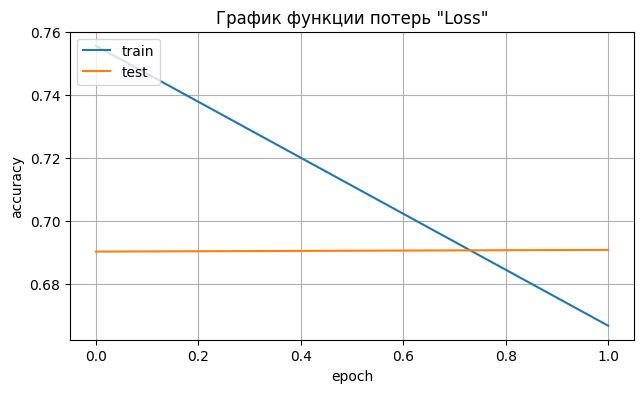

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)

ax.plot(list(map(np.mean, history_training['accuracy'])), label='train')
ax.plot(list(map(np.mean, history_validation['accuracy'])), label='test')
ax.set_title('График точности "Accuracy"')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.plot(list(map(np.mean, history_training['loss'])), label='train')
ax.plot(list(map(np.mean, history_validation['loss'])), label='test')
ax.set_title('График функции потерь "Loss"')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)
plt.show()

In [ ]:
predicted_labels = predict(model, params, test_loader)

display_image_grid(test_images_filepaths, predicted_labels)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\collate.py", line 264, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\collate.py", line 171, in collate_numpy_array_fn
    return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "C:\Users\kalmykovyaa\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\_utils\collate.py", line 161, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [16]:
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
y_pred = predict(model, params, test_loader)

In [18]:
conf_matrix(model, params, train_loader)

ValueError: At least one label specified must be in y_true